In [189]:
import pandas as pd
from datetime import date, timedelta
import numpy as np
import matplotlib.pyplot as plt
import warnings
import tensorflow
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")

In [159]:
df = pd.read_csv('data_cleaned.csv')

In [160]:
df

,height_x,weight_x,reach_x,fight_time_sum_x,kds_per_min_x,sub_att_per_min_x,pass_per_min_x,rev_per_min_x,tds_acc_x,tds_succ_per_min_x,tds_att_per_min_x,tot_str_acc_x,tot_str_succ_per_min_x,tot_str_att_per_min_x,sig_str_head_acc_x,sig_str_head_succ_per_min_x,sig_str_head_att_per_min_x,sig_str_body_acc_x,sig_str_body_succ_per_min_x,sig_str_body_att_per_min_x,sig_str_leg_acc_x,sig_str_leg_succ_per_min_x,sig_str_leg_att_per_min_x,sig_str_dist_acc_x,sig_str_dist_succ_per_min_x,sig_str_dist_att_per_min_x,sig_str_clinch_acc_x,sig_str_clinch_succ_per_min_x,sig_str_clinch_att_per_min_x,sig_str_ground_acc_x,sig_str_ground_succ_per_min_x,sig_str_ground_att_per_min_x,age_x,weightclass_Bantamweight_x,weightclass_Catch Weight_x,weightclass_Featherweight_x,weightclass_Flyweight_x,weightclass_Heavyweight_x,weightclass_Light Heavyweight_x,weightclass_Lightweight_x,weightclass_Middleweight_x,weightclass_Open Weight_x,weightclass_Strawweight_x,weightclass_Super Heavyweight_x,weightclass_Welterweight_x,stance_Open Stance_x,stance_Orthodox_x,stance_Sideways_x,stance_Southpaw_x,stance_Switch_x,height_y,weight_y,reach_y,fight_time_sum_y,kds_per_min_y,sub_att_per_min_y,pass_per_min_y,rev_per_min_y,tds_acc_y,tds_succ_per_min_y,tds_att_per_min_y,tot_str_acc_y,tot_str_succ_per_min_y,tot_str_att_per_min_y,sig_str_head_acc_y,sig_str_head_succ_per_min_y,sig_str_head_att_per_min_y,sig_str_body_acc_y,sig_str_body_succ_per_min_y,sig_str_body_att_per_min_y,sig_str_leg_acc_y,sig_str_leg_succ_per_min_y,sig_str_leg_att_per_min_y,sig_str_dist_acc_y,sig_str_dist_succ_per_min_y,sig_str_dist_att_per_min_y,sig_str_clinch_acc_y,sig_str_clinch_succ_per_min_y,sig_str_clinch_att_per_min_y,sig_str_ground_acc_y,sig_str_ground_succ_per_min_y,sig_str_ground_att_per_min_y,age_y,weightclass_Bantamweight_y,weightclass_Catch Weight_y,weightclass_Featherweight_y,weightclass_Flyweight_y,weightclass_Heavyweight_y,weightclass_Light Heavyweight_y,weightclass_Lightweight_y,weightclass_Middleweight_y,weightclass_Open Weight_y,weightclass_Strawweight_y,weightclass_Super Heavyweight_y,weightclass_Welterweight_y,stance_Open Stance_y,stance_Orthodox_y,stance_Sideways_y,stance_Southpaw_y,stance_Switch_y,fx_win
0,1.75,135.0,1.78,15.00,0.00,0.07,0.07,0.07,0.00,0.00,0.00,0.80,7.27,9.13,0.22,0.33,1.53,0.86,0.80,0.93,0.33,0.07,0.20,0.35,0.60,1.73,0.50,0.20,0.40,0.75,0.40,0.53,25.05,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.78,135.0,1.78,2.78,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.26,2.52,9.71,0.10,0.72,7.55,0.50,0.36,0.72,1.00,1.44,1.44,0.20,1.80,8.99,1.00,0.72,0.72,0.00,0.00,0.00,27.63,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1.73,155.0,1.75,15.00,0.00,0.07,0.07,0.00,0.00,0.00,0.20,0.55,6.20,11.33,0.22,1.20,5.53,0.90,1.20,1.33,0.70,1.27,1.80,0.37,2.07,5.53,0.51,1.60,3.13,0.00,0.00,0.00,25.10,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1.70,155.0,1.78,9.72,0.00,0.31,0.10,0.00,0.50,0.10,0.21,0.48,2.26,4.73,0.32,0.93,2.88,0.50,0.31,0.62,0.50,0.10,0.21,0.33,0.93,2.78,0.38,0.31,0.82,1.00,0.10,0.10,29.69,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,1.73,155.0,1.75,20.00,0.00,0.05,0.10,0.00,0.29,0.10,0.35,0.54,5.50,10.10,0.20,1.00,4.90,0.88,1.10,1.25,0.73,1.10,1.50,0.33,1.60,4.80,0.55,1.55,2.80,1.00,0.05,0.05,27.93,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1.70,155.0,1.75,89.80,0.00,0.01,0.07,0.02,0.25,0.06,0.22,0.44,5.39,12.35,0.26,2.23,8.51,0.57,0.14,0.26,0.82,0.81,0.99,0.27,2.05,7.47,0.58,0.50,0.87,0.45,0.63,1.41,31.81,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
3,1.73,155.0,1.75,35.73,0.00,0.03,0.06,0.00,0.38,0.08,0.22,0.52,6.91,13.21,0.30,2.32,7.70,0.83,1.23,1.48,0.70,1.09,1.57,0.37,2.94,8.00,0.61,1.46,2.38,0.69,0.25,0.36,28.66,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1.75,155.0,1.78,0.73,1.37,0.00,0.00,0.00,0.00,0.00,0.00,0.42,6.85,16.44,0.40,5.48,13.70,1.00,1.37,1.37,0.00,0.00,1.37,0.33,2.74,8.22,0.00,0.00,1.37,0.60,4.11,6.85,24.69,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
4,1.73,155.0,1.75,60.36,0.00,0.02,0.05,0.00,0.33,0.08,0.25,0.54,6.96,13.01,0.27,1.94,7.07,0.80,1.14,1.42,0.68,0.75,1.09,0.31,2.14,6.88,0.60,1.38,2.29,0.73,0.31,0.43,29.47,0,0,0,0,0,

In [161]:
len(df.columns)

101

In [162]:
y = df[['fx_win']]

In [163]:
X = df.drop(columns=['fx_win'])

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=700, random_state=50)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=50)

In [165]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

In [187]:
xtraindf = pd.DataFrame(X_train_s)

In [188]:
xtraindf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.638369,0.370793,0.404575,3.713729,-0.015849,-0.258425,0.000617,-0.178752,0.804960,-0.592526,-0.812982,0.200159,-0.768813,-0.998949,0.298561,-0.484784,-0.779142,0.092127,0.086354,0.103666,-0.053840,0.147170,0.253685,0.935129,-0.180326,-0.531145,0.321278,-0.454205,-0.528130,-0.022644,-0.228130,-0.199459,2.135962,-0.3104,-0.028341,-0.320398,-0.224923,-0.318109,-0.263681,-0.484019,2.031643,-0.098613,-0.17125,0.0,-0.48465,-0.049128,-1.766071,-0.028341,1.976237,-0.19245,0.439470,0.372750,0.444166,1.293801,0.230279,-0.052063,-0.433007,-0.183749,1.268370,-0.663104,-0.946867,-0.107852,-1.006652,-1.210072,0.620364,-0.273952,-0.637067,0.218537,-0.733303,-0.810601,0.500741,-0.798395,-0.864014,-0.055202,-0.827487,-0.932316,-0.235820,-0.096884,0.022150,0.251505,0.042657,0.032831,2.430309,-0.3104,-0.028341,-0.319636,-0.228834,-0.318109,-0.263681,-0.475792,2.068734,-0.098613,-0.170005,0.0,-0.500376,-0.044838,-1.781630,0.0,1.933298,-0.16494
1,-0.181820,-0.494202,-0.389050,-0.773832,0.016261,-0.484971,-0.491380,-0.490693,1.199418,0.365408,-0.217499,1.339485,0.142416,-0.466377,0.792267,-0.392436,-0.790451,0.141046,-0.683155,-0.778127,0.309327,1.505145,1.341105,1.182985,-0.360246,-0.751513,1.194770,-0.227641,-0.450459,0.221992,0.117261,0.125666,-0.964144,-0.3104,-0.028341,-0.320398,-0.224923,-0.318109,-0.263681,2.066035,-0.492213,-0.098613,-0.17125,0.0,-0.48465,-0.049128,0.566229,-0.028341,-0.506012,-0.19245,-0.497064,-0.485747,0.142212,0.312229,-0.017857,0.039822,0.103628,1.033266,2.169482,-0.896612,-1.151228,0.972464,-0.625499,-1.120658,0.127082,-0.814746,-1.167680,0.658198,-0.438810,-0.607757,0.541861,0.196606,0.055447,1.005010,-0.812432,-1.103189,0.458709,-0.022802,-0.102706,-0.402894,-0.291594,-0.199235,-0.564287,-0.3104,-0.028341,-0.319636,-0.228834,-0.318109,-0.263681,2.101759,-0.483387,-0.098613,-0.170005,0.0,-0.500376,-0.044838,-1.781630,0.0,1.933298,-0.16494
2,0.638369,1.351120,0.106966,-0.583696,-0.080070,-0.484971,0.431114,1.692890,0.661521,-0.193387,-0.455692,2.023080,0.481303,-0.388501,1.697395,-0.269305,-0.832858,1.364038,0.509583,0.058056,0.995309,-0.948739,-1.002471,-0.882481,-1.246009,-1.370355,0.229331,0.382339,0.416860,1.118989,0.664131,0.381824,0.076590,-0.3104,-0.028341,-0.320398,-0.224923,-0.318109,-0.263681,-0.484019,-0.492213,10.140677,-0.17125,0.0,-0.48465,-0.049128,0.566229,-0.028341,-0.506012,-0.19245,0.439470,0.515833,-0.059090,-0.911789,-0.183281,-0.603372,-0.850389,2.858788,-1.434967,-0.974448,-1.192100,0.818133,-1.180656,-1.634790,1.606930,-1.104457,-1.671596,-3.347604,-1.259184,-1.169479,0.994188,-0.656252,-0.785762,3.832240,-1.166209,-1.533536,-2.967637,-0.852527,-0.829137,-0.484694,-0.458719,-0.403171,-2.901975,-0.3104,-0.028341,-0.319636,-0.228834,-0.318109,-0.263681,-0.475792,-0.483387,10.140677,-0.170005,0.0,-0.500376,-0.044838,0.561284,0.0,-0.517251,-0.16494
3,-0.767670,-0.494202,-1.083471,1.538123,-0.047960,-0.484971,-0.860378,-0.490693,-1.490067,-0.991666,-1.051175,-0.255571,0.116058,0.282239,0.298561,0.218087,0.139677,-0.445989,1.490707,2.247333,0.188271,1.457497,1.416099,1.182985,1.881840,1.159351,-0.736107,-0.611056,-0.476350,-0.511916,-0.400826,-0.362021,0.653303,-0.3104,-0.028341,-0.320398,-0.224923,-0.318109,-0.263681,2.066035,-0.492213,-0.098613,-0.17125,0.0,-0.48465,-0.049128,0.566229,-0.028341,-0.506012,-0.19245,-0.731198,-0.485747,-0.864299,3.171757,-0.100569,-0.603372,-0.790763,-0.488002,0.367257,-0.507432,-0.701634,-0.879506,-0.389350,0.094819,-0.695056,-0.170943,0.277323,-0.221124,0.760197,1.014998,0.295138,0.362440,0.329329,0.033149,0.768272,0.871345,0.180897,-0.289499,-0.307014,-0.321094,-0.566859,-0.578978,0.783508,-0.3104,-0.028341,-0.319636,-0.228834,-0.318109,-0.263681,2.101759,-0.483387,-0.098613,

In [167]:
y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

In [191]:
log_reg = LogisticRegression()
log_reg.fit(X_train_s, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [196]:
score = log_reg.score(X_val_s, y_val)
score

0.5613636363636364

In [181]:
model = Sequential()
model.add(Dense(10, activation='relu', input_dim=X_train_s.shape[1]))
# # # Dropout(rate=0.5)
model.add(Dense(10, activation='relu'))
# # Dropout(rate=0.5)
model.add(Dense(10, activation='relu'))
# Dropout(rate=0.5)
model.add(Dense(1, activation='sigmoid'))

In [182]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_143 (Dense)            (None, 10)                1010      
_________________________________________________________________
dense_144 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_145 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_146 (Dense)            (None, 1)                 11        
Total params: 1,241
Trainable params: 1,241
Non-trainable params: 0
_________________________________________________________________


In [183]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [186]:
history = model.fit(X_train_s, y_train, epochs=1, validation_data=(X_val_s, y_val))

Train on 2492 samples, validate on 440 samples
Epoch 1/1
2492/2492 [==============================] - 0s 64us/step - loss: 0.2254 - accuracy: 0.9037 - val_loss: 3.4153 - val_accuracy: 0.4955


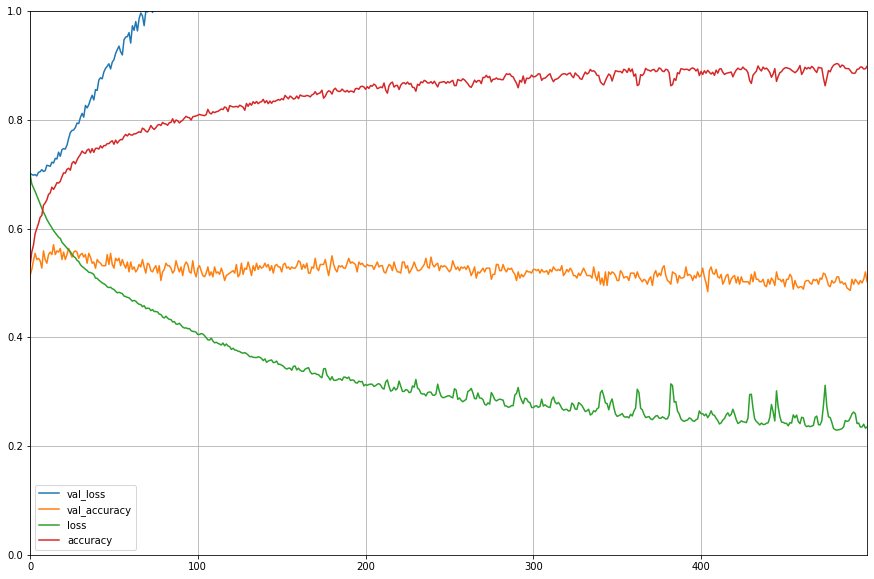

In [185]:
pd.DataFrame(history.history).plot(figsize=(15,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()